In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import prince

import gower

import plotly.express as px
from ipywidgets import interact

%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

<IPython.core.display.Javascript object>

### Load in and Prepare Data

Data is cleaned and explored in accompanying notebook.

In [3]:
loans = pd.read_csv("data/SBA_clnd.csv")
loans.head()

,Name,City,State,Zip,Bank,BankState,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,Term_years,UrbanRural_cleaned,Disbr_year,Disbr_Month_sin,Disbr_Month_cos,sba_pre_approv,percent_SBA,bank_size,Appv_Month_sin,Appv_Month_cos
0,CARVEL,APEX,NC,27502,STEARNS BK NATL ASSOC,MN,2006,2,1,0,0,0.0,0.0,253400.0,0,44,1.0,0,13.500000,0.0,2006,0.866025,5.000000e-01,1.0,0.75,1.0,0.5,0.866025
1,SUBWAY,LITTLE ROCK,AR,72223,HOPE FCU,MS,2006,7,0,0,0,0.0,0.0,137300.0,0,72,0.0,0,10.500000,0.0,2006,1.000000,6.123234e-17,1.0,0.85,0.0,0.5,0.866025
2,WEYLAND CORPORATION,CAMARILLO,CA,93010,WELLS FARGO BANK NATL ASSOC,SD,2006,18,1,5,23,1.0,0.0,438541.0,0,61,0.0,0,6.916667,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
3,CHICAGO BRICK UNLIMITED INC,MIAMI,FL,33186,"CITIBANK, N.A.",FL,2006,4,0,0,4,1.0,0.0,51440.0,0,23,0.0,1,7.000000,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
4,"RZI, INC.",NEW ORLEANS,LA,70130,BUSINESS RES. CAP. SPECIALTY B,LA,2006,3,0,0,0,0.0,0.0,50000.0,0,53,0.0,1,5.000000,0.0,2006,0.866025,-5.000000e-01,1.0,0.85,0.0,0.5,0.866025


<IPython.core.display.Javascript object>

Create a column to represent the size of a bank by the number of loans given over this period

In [4]:
bank_counts = loans["Bank"].value_counts()
loans["bank_size"] = loans["Bank"].apply(lambda x: bank_counts[x])

<IPython.core.display.Javascript object>

Select defaulted loans only.

In [64]:
default = loans[loans["MIS_Status"] == 1]
#default = default[default["NoEmp"] <= 100]


<IPython.core.display.Javascript object>

Drop columns not useful for clustering

In [7]:
drop_cols = [
    "Name",
    "City",
    "Zip",
    "Bank",
    "ApprovalFY",
    "sba_pre_approv",
    "Disbr_Month_sin",
    "Disbr_Month_cos",
    "Appv_Month_sin",
    "Appv_Month_cos",
    "MIS_Status",
    "twoDigNAICS",
    "State",
    "BankState",
]
default = default.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

Categorize columns into numerica and categorical for preprocessing

In [8]:
num_cols = [
    "NoEmp",
    "CreateJob",
    "RetainedJob",
    "DisbursementGross",
    "Term_years",
    "Disbr_year",
    "percent_SBA",
    "bank_size",
]

cat_cols = [
    "NewExist",
    "RevLineCr",
    "LowDoc",
    "is_franchise",
    "bank_out_of_state",
    "UrbanRural_cleaned",
]

# will want cat_cols as str for discrete coloring in graphs
# converting here breaks famd
# loans[cat_cols] = loans[cat_cols].astype("str")
is_cat = default.columns.isin(cat_cols)

<IPython.core.display.Javascript object>

In [9]:
default.head()

,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,is_franchise,bank_out_of_state,Term_years,UrbanRural_cleaned,Disbr_year,percent_SBA,bank_size
8,9,0,0,9,0.0,0.0,1350000.0,0.0,0,13.916667,0.0,2006,0.75,24752
11,4,1,1,5,1.0,0.0,60859.0,0.0,0,2.166667,1.0,2006,0.50,24752
15,1,1,3,4,0.0,0.0,28090.0,0.0,0,0.416667,0.0,2006,0.85,20370
16,4,0,8,4,1.0,0.0,76432.0,0.0,0,4.500000,1.0,2006,0.50,34974
24,10,0,11,10,1.0,0.0,90518.0,0.0,0,2.250000,0.0,2006,0.50,24752


<IPython.core.display.Javascript object>

Sample 1,000 loans so distance matrixes and clustering algorithms run in a reasonable amount of time.

In [10]:
sample = default.sample(1000, random_state = 66)

# will want cat_cols as str for discrete coloring in graphs
sample[cat_cols] = sample[cat_cols].astype("str")
sample.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 310469 to 302209
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NoEmp               1000 non-null   int64  
 1   NewExist            1000 non-null   object 
 2   CreateJob           1000 non-null   int64  
 3   RetainedJob         1000 non-null   int64  
 4   RevLineCr           1000 non-null   object 
 5   LowDoc              1000 non-null   object 
 6   DisbursementGross   1000 non-null   float64
 7   is_franchise        1000 non-null   object 
 8   bank_out_of_state   1000 non-null   object 
 9   Term_years          1000 non-null   float64
 10  UrbanRural_cleaned  1000 non-null   object 
 11  Disbr_year          1000 non-null   int64  
 12  percent_SBA         1000 non-null   float64
 13  bank_size           1000 non-null   int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 117.2+ KB


<IPython.core.display.Javascript object>

### Calculate Gower Distance Matrix for Mixed Data

In [11]:
gower_dist = gower.gower_matrix(sample, cat_features=is_cat)
gower_df = pd.DataFrame(gower_dist, columns=sample.index, index=sample.index)

<IPython.core.display.Javascript object>

Scale the numerical features for clustering to give features equal voices

In [12]:
scaler = StandardScaler()
X_std = scaler.fit_transform(sample[num_cols])
X_std = pd.DataFrame(X_std, columns=num_cols, index=sample[num_cols].index)
# pd.DataFrame(scaler.fit_transform(X[num_cols]), columns=num_cols)

scaled_X = pd.concat((X_std, sample[cat_cols]), axis=1)

# for after cluster, doing some preliminary visualization
# scaled_X["label"] = labels
scaled_X

,NoEmp,CreateJob,RetainedJob,DisbursementGross,Term_years,Disbr_year,percent_SBA,bank_size,NewExist,RevLineCr,LowDoc,is_franchise,bank_out_of_state,UrbanRural_cleaned
310469,-0.263979,1.532731,0.259196,0.652080,1.409945,-1.988538,0.959673,0.061195,0,0.0,0.0,0.0,0,0.0
139568,-0.328348,-0.452672,-0.324908,-0.354792,-0.313059,0.601379,-0.670206,0.061195,0,1.0,0.0,0.0,0,0.0
155456,-0.006501,-0.169043,0.040157,-0.463888,0.187168,0.601379,-0.670206,-1.063051,1,1.0,0.0,0.0,0,0.0
83352,-0.263979,-0.452672,-0.251895,-0.463888,-0.174107,0.083395,-0.670206,0.528960,0,0.0,0.0,0.0,1,0.0
42980,-0.328348,0.398215,-0.105869,-0.446719,-1.091189,-0.434588,-0.670206,-0.250023,1,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426421,-0.328348,-0.452672,-0.324908,-0.435273,0.465072,-0.952571,-0.670206,1.857574,0,1.0,0.0,0.0,0,0.0
40082,-0.135240,-0.169043,-0.032856,-0.462171,-0.479801,-0.434588,-0.670206,0.528960,0,0.0,0.0,0.0,1,0.0
3956,-0.199609,-0.452672,-0.178882,-0.251831,0.187168,0.083395,-0.670206,0.528960,0,1.0,0.0,0.0,0,0.0
312345,-0.070871,-0.452672,-0.032856,0.051175,3.132949,-1.988538,1.611624,-1.037883,0,0.0,0.0,0.0,1,0.0


<IPython.core.display.Javascript object>

In [13]:
scaled_X.describe()

,NoEmp,CreateJob,RetainedJob,DisbursementGross,Term_years,Disbr_year,percent_SBA,bank_size
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-3.552714e-18,-1.421085e-17,-7.105427e-18,2.842171e-17,-1.296740e-16,3.014033e-14,-8.881784e-17,5.329071e-17
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-3.927175e-01,-4.526720e-01,-3.979210e-01,-5.783460e-01,-1.424674e+00,-2.506521e+00,-6.702387e-01,-1.071426e+00
25%,-3.283481e-01,-4.526720e-01,-3.249080e-01,-4.638877e-01,-6.465432e-01,-4.345879e-01,-6.702060e-01,-8.898018e-01
50%,-1.996094e-01,-4.526720e-01,-2.518950e-01,-3.171522e-01,-1.185260e-01,8.339530e-02,-6.702060e-01,-1.905795e-01
75%,-6.501306e-03,1.145861e-01,-3.285586e-02,5.676723e-02,4.094913e-01,6.013785e-01,9.596727e-01,5.289604e-01
max,1.891809e+01,8.056200e+00,2.296625e+01,1.083887e+01,6.356633e+00,3.709278e+00,2.589551e+00,1.857574e+00


<IPython.core.display.Javascript object>

### Dimension Reduction

Factor Analysis of Mixed Data is ran to visualize the sample. Most of the variation appears to be on one axis.

In [14]:
famd = prince.FAMD(n_components=2)
famd.fit(scaled_X)

FAMD(check_input=True, copy=True, engine='auto', n_components=2, n_iter=3,
     random_state=None)

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


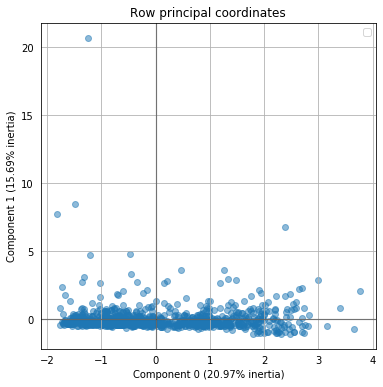

<IPython.core.display.Javascript object>

In [15]:
famd.plot_row_coordinates(
    scaled_X, alpha=0.5, ellipse_fill=False,
)
plt.show()

In [16]:
# store the famd coordinates to do custom plotting
sample["famd_x"] = famd.row_coordinates(scaled_X).iloc[:, 0]
sample["famd_y"] = famd.row_coordinates(scaled_X).iloc[:, 1]

<IPython.core.display.Javascript object>

Just from the Factor Analysis, it appears there are at least two dense clusters, with some outliers. DBSCAN should perform excellently here.

* Note: DBSCAN did not perform well due to sparse, subtle clusters. K-medoids was chosen to counter skew, however transforming the data may result in different cluster separations.

### K-Medoids

In [17]:
np.random.seed(613)
k = 3
nrows = gower_df.shape[0]
init_medoids = np.random.randint(0, nrows, k)
init_medoids

array([866, 766, 472])

<IPython.core.display.Javascript object>

In [18]:
kmed = kmedoids(
    gower_dist, initial_index_medoids=init_medoids, data_type="distance_matrix",
)

kmed.process()

<IPython.core.display.Javascript object>

In [19]:
labels = kmed.predict(gower_dist)
sample_kmeds = sample.copy()
sample_kmeds["label"] = labels
sample_kmeds["label"] = sample_kmeds["label"].astype("str")
sample_kmeds["label"].value_counts(normalize=True)

1    0.532
0    0.272
2    0.196
Name: label, dtype: float64

<IPython.core.display.Javascript object>

In [20]:
num_cols_labels = num_cols.copy()
num_cols_labels.append("label")
clst_avg = sample_kmeds[num_cols_labels].groupby("label").mean().T
clst_avg.style.background_gradient(axis=1)

label,0,1,2
NoEmp,6.040441,5.524436,7.750000
CreateJob,2.485294,0.962406,2.081633
RetainedJob,4.371324,5.285714,7.392857
DisbursementGross,186368.147059,65699.298872,104152.030612
Term_years,6.228554,3.391291,3.947704
Disbr_year,2005.687500,2005.894737,2005.897959
percent_SBA,0.792647,0.506203,0.601531
bank_size,6084.709559,35556.714286,14507.617347


<IPython.core.display.Javascript object>

In [21]:
cat_cols_labels = cat_cols.copy()
cat_cols_labels.append("label")
clst_avg = sample_kmeds[cat_cols_labels].groupby("label").agg(pd.Series.mode).T
clst_avg.style.background_gradient(axis=1)

label,0,1,2
NewExist,1,0,0
RevLineCr,0.0,1.0,0.0
LowDoc,0.0,0.0,0.0
is_franchise,0.0,0.0,0.0
bank_out_of_state,1,0,0
UrbanRural_cleaned,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [22]:
@interact
def plot(color=sample_kmeds.columns, opacity=(0, 1.0)):
    fig = px.scatter(
        data_frame=sample_kmeds,
        x="famd_x",
        y="famd_y",
        color=color,
        hover_data=["DisbursementGross", "LowDoc", "label"],
        # symbol="label",
    )
    fig.update_traces(marker={"opacity": opacity})
    fig.show()

interactive(children=(Dropdown(description='color', options=('NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', …

<IPython.core.display.Javascript object>

### DBSCAN

In [23]:
clst = DBSCAN(eps=0.1, min_samples=10, metric="precomputed")
clst.fit(gower_df)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

<IPython.core.display.Javascript object>

In [24]:
sample_dbscan = sample.copy()
sample_dbscan["label"] = clst.labels_
sample_dbscan["label"] = sample_dbscan["label"].astype("str")
sample_dbscan["label"].value_counts()

0     988
-1     12
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [25]:
num_cols_labels = num_cols.copy()
num_cols_labels.append("label")
clst_avg = sample_dbscan[num_cols_labels].groupby("label").mean().T
clst_avg.style.background_gradient(axis=1)

label,-1,0
NoEmp,43.666667,5.644737
CreateJob,6.333333,1.538462
RetainedJob,36.916667,5.067814
DisbursementGross,320738.416667,103450.506073
Term_years,6.458333,4.245530
Disbr_year,2006.083333,2005.836032
percent_SBA,0.700000,0.601619
bank_size,9069.166667,23588.943320


<IPython.core.display.Javascript object>

In [26]:
cat_cols_labels = cat_cols.copy()
cat_cols_labels.append("label")
clst_avg = sample_dbscan[cat_cols_labels].groupby("label").agg(pd.Series.mode).T
clst_avg.style.background_gradient(axis=1)

label,-1,0
NewExist,1,0
RevLineCr,0.0,0.0
LowDoc,0.0,0.0
is_franchise,1.0,0.0
bank_out_of_state,1,0
UrbanRural_cleaned,1.0,0.0


<IPython.core.display.Javascript object>

In [27]:
# for dbscan, get rid of outliers
sample_dbscan = sample_dbscan[sample_dbscan["label"] != "-1"]


@interact
def plot(color=sample_dbscan.columns, opacity=(0, 1.0)):
    fig = px.scatter(
        data_frame=sample_dbscan,
        x="famd_x",
        y="famd_y",
        color=color,
        hover_data=["DisbursementGross", "LowDoc", "label"],
        # symbol="label",
    )
    fig.update_traces(marker={"opacity": opacity})
    fig.show()

interactive(children=(Dropdown(description='color', options=('NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', …

<IPython.core.display.Javascript object>

### Hierarchical

In [104]:
clst = AgglomerativeClustering(n_clusters=4, affinity="precomputed", linkage="complete")
clst.fit(gower_df)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=4)

<IPython.core.display.Javascript object>

In [105]:
sample_hier = sample.copy()
sample_hier["label"] = clst.labels_
sample_hier["label"] = sample_hier["label"].astype("str")
sample_hier["label"].value_counts()

1    548
0    380
2     71
3      1
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [30]:
num_cols_labels = num_cols.copy()
num_cols_labels.append("label")
clst_avg = sample_hier[num_cols_labels].groupby("label").mean().T
clst_avg.style.background_gradient(axis=1)

label,0,1,2,3
NoEmp,5.228947,6.228102,5.647887,300.000000
CreateJob,2.389474,1.118613,0.774648,20.000000
RetainedJob,4.723684,5.870438,1.661972,320.000000
DisbursementGross,143800.576316,76392.895985,129015.788732,390314.000000
Term_years,5.224561,3.390207,6.011737,2.083333
Disbr_year,2006.134211,2005.788321,2004.647887,2006.000000
percent_SBA,0.695526,0.511953,0.809155,0.500000
bank_size,14843.802632,32078.160584,1848.183099,64008.000000


<IPython.core.display.Javascript object>

In [31]:
cat_cols_labels = cat_cols.copy()
cat_cols_labels.append("label")
clst_avg = sample_hier[cat_cols_labels].groupby("label").agg(pd.Series.mode).T
clst_avg.style.background_gradient(axis=1)

label,0,1,2,3
NewExist,1,0,1,0
RevLineCr,0.0,1.0,0.0,1.0
LowDoc,0.0,0.0,1.0,0.0
is_franchise,0.0,0.0,0.0,1.0
bank_out_of_state,0,0,1,0
UrbanRural_cleaned,0.0,0.0,1.0,0.0


<IPython.core.display.Javascript object>

In [32]:
@interact
def plot(color=sample_hier.columns, opacity=(0, 1.0)):
    fig = px.scatter(
        data_frame=sample_hier,
        x="famd_x",
        y="famd_y",
        color=color,
        hover_data=["DisbursementGross", "LowDoc", "label"],
        # symbol="label",
    )
    fig.update_traces(marker={"opacity": opacity})
    fig.show()

interactive(children=(Dropdown(description='color', options=('NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', …

<IPython.core.display.Javascript object>

### Clustering Notes

DBSCAN tended to create a large outliers clusters, or too many small clusters. This is likely due to the sparseness of the data. Some of these clusters may be informative, but may not represent larger trends. Heirarchical clustering also had similar results, with a large majority class and remaining clusters orders of magnitude smaller. K-Medoids was chosen as the best algorithm and as way to address skew, since median measures are more resilient to outliers. Three clusters were chosen as larger values of K seemed to result in 2 consistent, distinct groups with the remaining clusters appearing similar to what is group 2 (index starting at 0) in the final clustering.

### Cluster Analysis Visualization

In [33]:
sample_kmeds["label"].value_counts()

1    532
0    272
2    196
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [107]:
# code to convert counts to percents for cluster comparison

sample_kmeds["bank_out_of_state"] = sample_kmeds["bank_out_of_state"].astype("int")
out_of_state_percs = pd.DataFrame(
    sample_kmeds.groupby("label")["bank_out_of_state"].agg("mean"),
)
sns.barplot(x=out_of_state_percs.index, y="bank_out_of_state", data=out_of_state_percs)

sample_kmeds["NewExist"] = sample_kmeds["NewExist"].astype("int")
new_exist_percs = pd.DataFrame(
    sample_kmeds.groupby("label")["NewExist"].agg("mean"),
)
sns.barplot(x=new_exist_percs.index, y="NewExist", data=new_exist_percs)
plt.close()


<IPython.core.display.Javascript object>

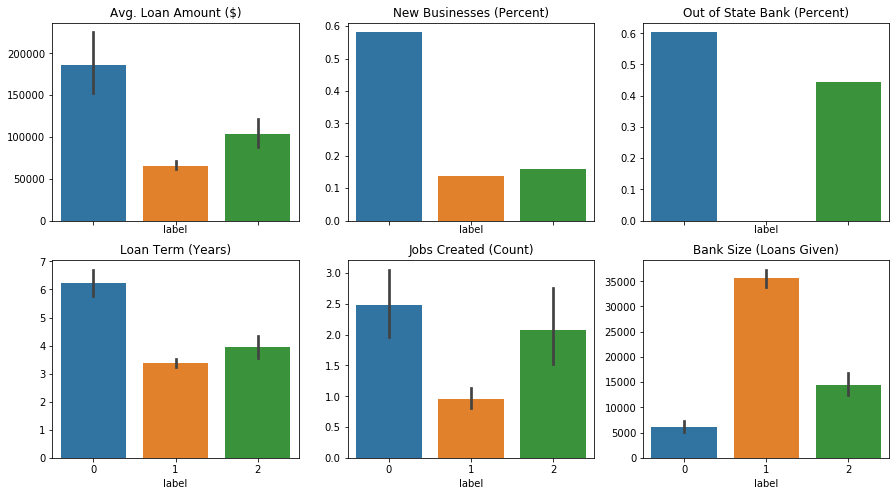

<IPython.core.display.Javascript object>

In [108]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
sns.barplot(ax=axs[0, 0], x="label", y="DisbursementGross", data=sample_kmeds)
axs[0, 0].set_title("Avg. Loan Amount ($)")
axs[0, 0].set_ylabel("")

sns.barplot(ax=axs[0, 1], x=new_exist_percs.index, y="NewExist", data=new_exist_percs)
# sns.countplot( x="label", hue="NewExist", data=sample_kmeds)
axs[0, 1].set_title("New Businesses (Percent)")
# axs[0, 1].legend(["No", "Yes"], loc="upper right")
axs[0, 1].set_ylabel("")

sns.barplot(
    ax=axs[0, 2],
    x=out_of_state_percs.index,
    y="bank_out_of_state",
    data=out_of_state_percs,
)
# sns.countplot( x="label", hue="bank_out_of_state", data=sample_kmeds)
axs[0, 2].set_title("Out of State Bank (Percent)")
axs[0, 2].set_ylabel("")

sns.barplot(ax=axs[1, 0], x="label", y="Term_years", data=sample_kmeds)
axs[1, 0].set_title("Loan Term (Years)")
axs[1, 0].set_ylabel("")

sns.barplot(ax=axs[1, 2], x="label", y="bank_size", data=sample_kmeds)
axs[1, 2].set_title("Bank Size (Loans Given)")
axs[1, 2].set_ylabel("")

sns.barplot(ax=axs[1, 1], x="label", y="CreateJob", data=sample_kmeds)
axs[1, 1].set_title("Jobs Created (Count)")
axs[1, 1].set_ylabel("")

fig.savefig("clusters.png")

plt.show()

Cluster 0: Failure to Launch

Features:
* Highest Percentage of New Businesses
Biggest Loans, Longest Average Loan Term
* Smallest Banks, but most out-of-state
* Created the most jobs

Interpretation: Promising new businesses that faltered

Suggested Actions:
* Consider for a second chance
* May need guidance and adjustments
* Connect with more conservative loans
<hr/>

Cluster 1: Business Burnout

Features:
* High percent of In-State Banks, Biggest Banks
* Highest percent of Existing Businesses
* Shortest Average Loan Term
* Created the Least Jobs
* Biggest Cluster (~500 loans)

Interpretation: Businesses with exhausted local credit options and slowing growth

Suggested Actions:
* Connect with new resources, out-of-state banks
* Help modernize
<hr/>

Cluster 2: Average Janes 

Features:
* Similar businesses to Group 2
* In-between loan sizes and terms
* Medium sized, in-state banks

Interpretation: Businesses on their way to burning out

Suggested Actions:
* Connect with new resources, bigger banks
* May have features of either first 2 groups
* Help overcome the obstacles that result in Cluster 2
* Build on the success that kep them from becoming Cluster 1




Some EDA

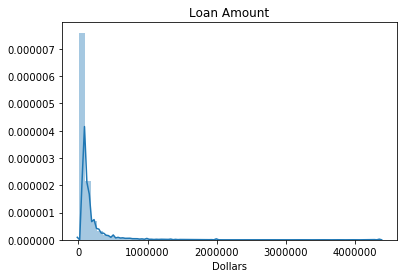

<IPython.core.display.Javascript object>

In [83]:
sns.distplot(default["DisbursementGross"])
plt.title("Loan Amount")
plt.xlabel("Dollars")
# plt.savefig("loan_amount.png")
plt.show()

In [46]:
default["DisbursementGross"].describe()

count    1.265270e+05
mean     1.157122e+05
std      1.986767e+05
min      4.000000e+03
25%      2.500000e+04
50%      5.143700e+04
75%      1.177455e+05
max      4.362157e+06
Name: DisbursementGross, dtype: float64

<IPython.core.display.Javascript object>

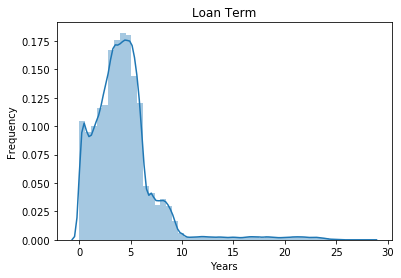

<IPython.core.display.Javascript object>

In [81]:
sns.distplot(default["Term_years"])
plt.title("Loan Term")
plt.xlabel("Years")
plt.ylabel("Frequency")
# plt.savefig("loan_term.png")
plt.show()

In [48]:
default["Term_years"].describe()

count    126527.000000
mean          4.319297
std           3.217526
min           0.000000
25%           2.416667
50%           4.000000
75%           5.416667
max          28.250000
Name: Term_years, dtype: float64

<IPython.core.display.Javascript object>

In [49]:
default["Term_years"].value_counts().sort_index()

0.000000      571
0.083333     1078
0.166667     1198
0.250000     1145
0.333333     1160
0.416667     1176
0.500000     1181
0.583333     1099
0.666667      960
0.750000      978
0.833333      884
0.916667      969
1.000000      952
1.083333      931
1.166667      957
1.250000      934
1.333333      977
1.416667     1046
1.500000     1048
1.583333     1089
1.666667     1135
1.750000     1099
1.833333     1088
1.916667     1162
2.000000     1171
2.083333     1221
2.166667     1240
2.250000     1311
2.333333     1398
2.416667     1345
2.500000     1433
2.583333     1470
2.666667     1439
2.750000     1414
2.833333     1524
2.916667     1549
3.000000     1677
3.083333     1735
3.166667     1770
3.250000     1772
3.333333     1891
3.416667     1829
3.500000     1931
3.583333     1751
3.666667     1815
3.750000     1696
3.833333     1774
3.916667     1800
4.000000     1833
4.083333     1866
4.166667     1877
4.250000     1784
4.333333     1835
4.416667     1904
4.500000     1938
4.583333  

<IPython.core.display.Javascript object>

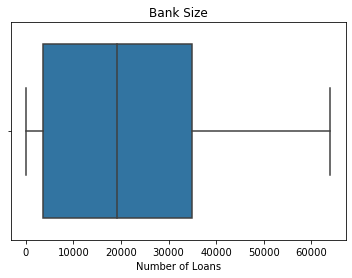

<IPython.core.display.Javascript object>

In [87]:
sns.boxplot(default["bank_size"])
plt.xlabel("Number of Loans")
plt.title("Bank Size")
#plt.savefig("bank_size.png")
plt.show()

In [51]:
default["bank_size"].describe()

count    126527.000000
mean      22936.661266
std       21848.878144
min           1.000000
25%        3562.000000
50%       19250.000000
75%       34974.000000
max       64008.000000
Name: bank_size, dtype: float64

<IPython.core.display.Javascript object>

In [52]:
default["bank_size"].value_counts().sort_index()

1          169
2          139
3          189
4          148
5          136
6          156
7          119
8          148
9          131
10         123
11         154
12         134
13         105
14         150
15         144
16         105
17         111
18          86
19          85
20         141
21          51
22          92
23          85
24         120
25         101
26         137
27         105
28         135
29         108
30         117
31         146
32          79
33          72
34          78
35          56
36          39
37          58
38          90
39          72
40         140
41          62
42          58
43          65
44         136
45          45
46          80
47          69
48         101
49          99
50          62
51          35
52          50
53          83
54          65
55         138
56          80
57          30
58          65
59          38
60          33
61          82
62          53
63          73
64          37
65         101
66          48
67        

<IPython.core.display.Javascript object>

C:\Users\dgump\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

divide by zero encountered in log



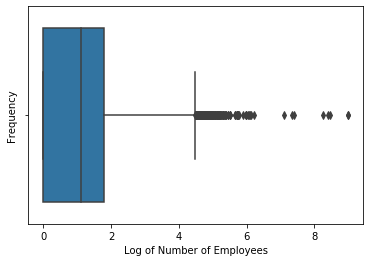

<IPython.core.display.Javascript object>

In [53]:
sns.boxplot(np.log(default["NoEmp"]))
plt.xlabel("Log of Number of Employees")
plt.ylabel("Frequency")
plt.show()

In [54]:
default["NoEmp"].value_counts().sort_index()

0        1536
1       30253
2       24160
3       15488
4       11731
5        9190
6        6377
7        4110
8        3717
9        1847
10       3466
11       1081
12       2106
13        758
14        867
15       1770
16        559
17        411
18        575
19        227
20       1145
21        248
22        333
23        199
24        205
25        712
26        152
27        111
28        147
29         64
30        548
31         63
32        112
33         60
34         71
35        271
36         70
37         34
38         63
39         29
40        260
41         27
42         60
43         26
44         21
45        145
46         25
47         25
48         34
49         15
50        193
51         10
52         22
53          8
54         14
55         52
56         11
57          8
58          9
59          7
60        106
61          5
62          6
63         11
64          8
65         51
66          4
67         10
68         13
70         38
71          3
72    

<IPython.core.display.Javascript object>

In [55]:
default["NoEmp"].describe()

count    126527.000000
mean          5.906755
std          40.397544
min           0.000000
25%           1.000000
50%           3.000000
75%           6.000000
max        8000.000000
Name: NoEmp, dtype: float64

<IPython.core.display.Javascript object>

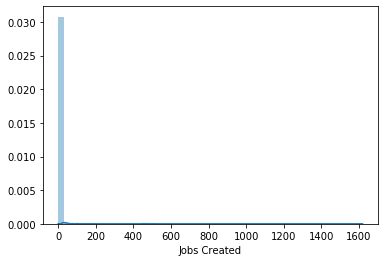

<IPython.core.display.Javascript object>

In [96]:
sns.distplot(default["CreateJob"])
plt.xlabel("Jobs Created")
plt.show()

In [99]:
default["CreateJob"].value_counts().sort_index()

0       72688
1       17685
2       14325
3        6073
4        3810
5        3145
6        1554
7         730
8         920
9         377
10       1605
11        166
12        448
13        172
14        198
15        588
16        111
17         60
18        123
19         71
20        461
21         29
22         54
23         54
24         51
25        201
26         27
27         25
28         40
29         16
30        167
31          7
32         18
33         15
34         12
35         43
36         14
37          8
38         13
39         10
40         70
41          2
42          5
43          4
44          2
45         18
46          4
47          2
48          1
49         10
50         73
51          2
52          3
53          1
54          5
55          9
56          2
58          2
59          1
60         18
63          1
64          1
65          7
67          1
68          3
69          2
70          3
72          3
73          1
75          8
77          2
78    

<IPython.core.display.Javascript object>

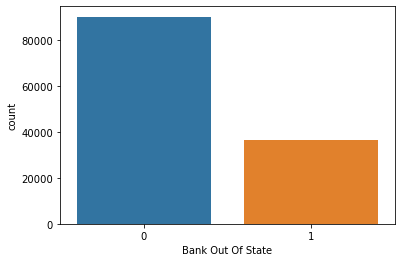

<IPython.core.display.Javascript object>

In [58]:
sns.countplot(x="NewExist", data=default)
plt.xlabel("Bank Out Of State")
plt.show()

In [59]:
default["NewExist"].value_counts(normalize=True)

0    0.711421
1    0.288579
Name: NewExist, dtype: float64

<IPython.core.display.Javascript object>

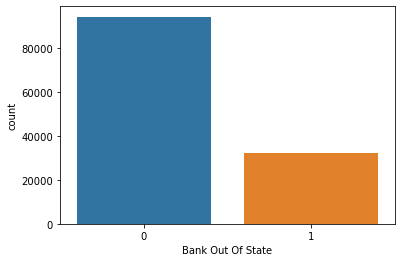

<IPython.core.display.Javascript object>

In [60]:
sns.countplot(x="bank_out_of_state", data=default)
plt.xlabel("Bank Out Of State")
plt.show()

In [61]:
default["bank_out_of_state"].value_counts(normalize=True)

0    0.744474
1    0.255526
Name: bank_out_of_state, dtype: float64

<IPython.core.display.Javascript object>

In [110]:
# long out put
# default.groupby("State")["bank_out_of_state"].value_counts(normalize=True)

State  bank_out_of_state
AK     0                    0.653061
       1                    0.346939
AL     0                    0.799386
       1                    0.200614
AR     1                    0.525602
       0                    0.474398
AZ     0                    0.961575
       1                    0.038425
CA     0                    0.645089
       1                    0.354911
CO     0                    0.928758
       1                    0.071242
CT     0                    0.768413
       1                    0.231587
DC     0                    0.977186
       1                    0.022814
DE     0                    0.682353
       1                    0.317647
FL     0                    0.933467
       1                    0.066533
GA     0                    0.870803
       1                    0.129197
HI     0                    0.510740
       1                    0.489260
IA     1                    0.629802
       0                    0.370198
ID     0     

<IPython.core.display.Javascript object>